In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob, sys
sys.path.insert(0, './')
import ramantools as rt

import pylab as pl
import numpy as np
import xarray as xr

In [3]:
%matplotlib inline

In [4]:
data_path = r'C:\Users\zrbyt\OneDrive - energia.mta.hu\Documents\work_MFA\ABC\G peak anomaly\Raman measurements'
data_path += '\\'

In [5]:
map_path = glob.glob(data_path + '*ABC_36*' + '*Data*')[0]
info_path = glob.glob(data_path + '*ABC_36*' + '*Information*')[0]

In [6]:
data_path_ss = 'test data/FLG36.MK_FLG_ABC_36--Spectrum--001--Spec.Data 1.txt'
info_path_ss = 'test data/FLG36.MK_FLG_ABC_36--Spectrum--001--Information.txt'

In [60]:
m = rt.ramanmap(map_path, info_path)

In [45]:
ss = rt.singlespec(data_path_ss, info_path_ss)

In [46]:
m_nobg, _, _ = m.remove_bg()

Values of starting parameters: 
 {'x0': 510.5, 'ampl': 10, 'width': 15, 'offset': 0} 

Values of fitted parameters:

x0 : 521.24
ampl : 267.78
width : 14.65
offset : 880.63


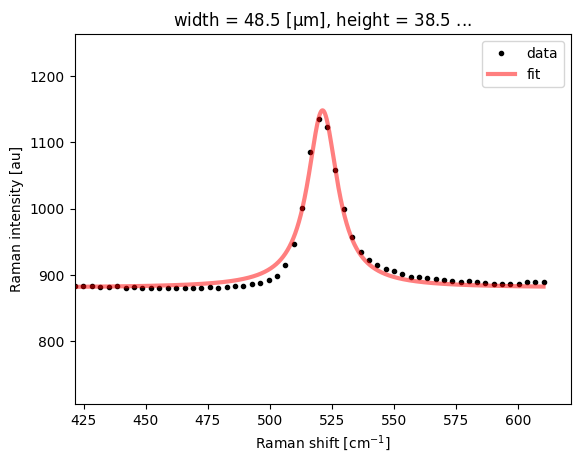

In [66]:
m = m.calibrate(510.5, toplot = True)

In [67]:
m.history()

Data modification history:

raw data loaded 
calibrated Raman shift by adding -10.74 cm^-1 to the raw ramanshift 



In [58]:
ss = ss.calibrate(520.5)

In [59]:
ss.history()

Data modification history:

raw data loaded 
calibrated Raman shift by adding -1.75 cm^-1 to the raw ramanshift
calibrated Raman shift by adding 70.60 cm^-1 to the raw ramanshift



Values of starting parameters: 
 {'x0': 2700, 'ampl': 10, 'width': 15, 'offset': 900} 

Fitted parameters: 
 [2723.19643732  313.57234099   49.25021492  902.99190735]


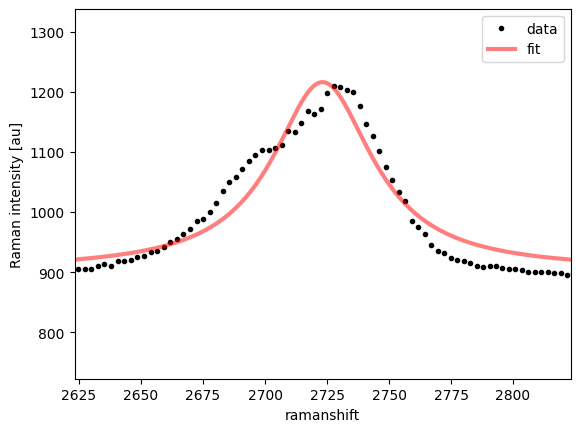

In [255]:
fitss = rt.peakfit(ss.ssxr, stval={'x0': 2700}, toplot = True)

Values of starting parameters: 
 {'x01': 2700, 'x02': 2731, 'ampl1': 1, 'width1': 15, 'ampl2': 1, 'width2': 15, 'offset': 900} 

Values of fitted parameters:

x01 : 2699.00
ampl1 : 159.22
width1 : 35.33
x02 : 2731.72
ampl2 : 287.53
width2 : 31.24
offset : 903.29


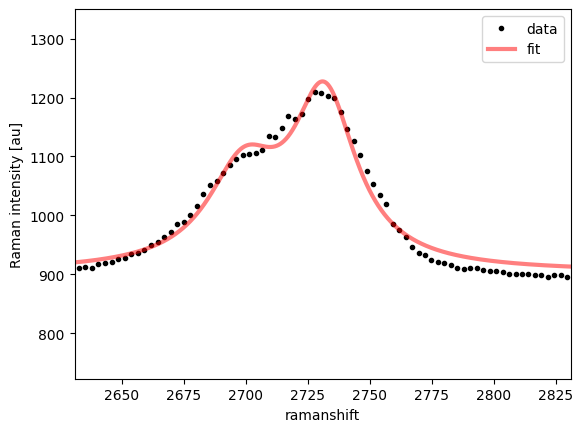

In [289]:
fitss = rt.peakfit(ss.ssxr, stval = {'x01': 2700, 'x02': 2731}, func = rt.lorentz2, toplot = True)

In [271]:
m_cropped = m_cropped.calibrate(520.5)

Values of starting parameters: 
 {'x0': 520, 'ampl': 10, 'width': 15, 'offset': 900} 

Values of fitted parameters:

x0 : 520.54
ampl : 256.51
width : -14.19
offset : 882.79


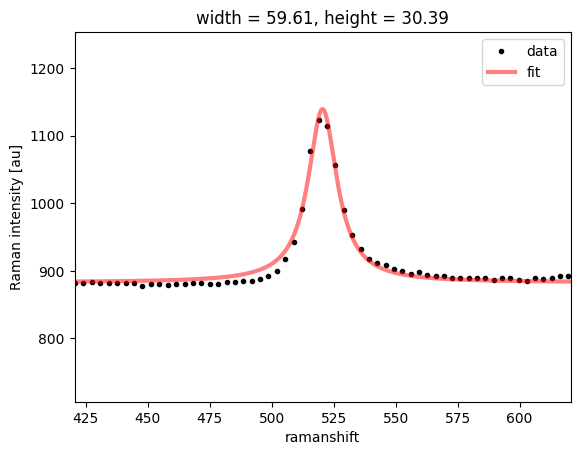

In [288]:
fitmap = rt.peakfit(m_cropped.mapxr, width = 60, height = 30, stval={'x0': 520}, toplot = True)

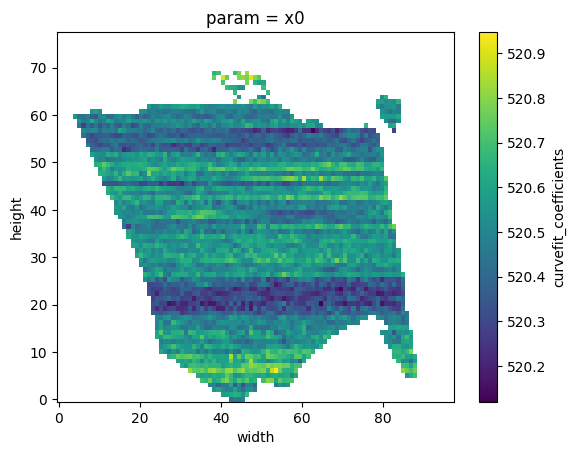

In [273]:
fitmap['curvefit_coefficients'].sel(param = 'x0').plot()

# Drawmask

In [150]:
map2d = m.mapxr.sel(ramanshift = slice(2550, 2850))

In [192]:
m_cropped, mask = m.peakmask(1580, cutoff=0.2)

In [193]:
m_cropped.history()

Data modification history:

raw data loaded 
Calibrated Raman shift by adding -1.23 cm^-1 to the raw ramanshift 
cropped regions, where mean Raman int. of peak: 1578.79 is less than 0.20 of selected peak



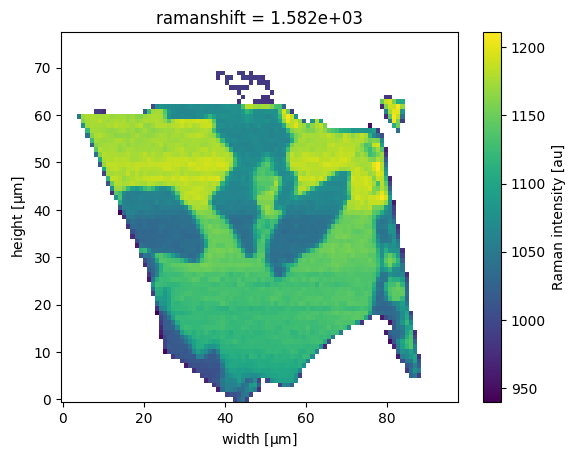

In [194]:
m_cropped.mapxr.sel(ramanshift = 1582, method = 'nearest').plot()

In [195]:
fit = rt.peakfit(m_cropped.mapxr, stval={'x0': 2700})

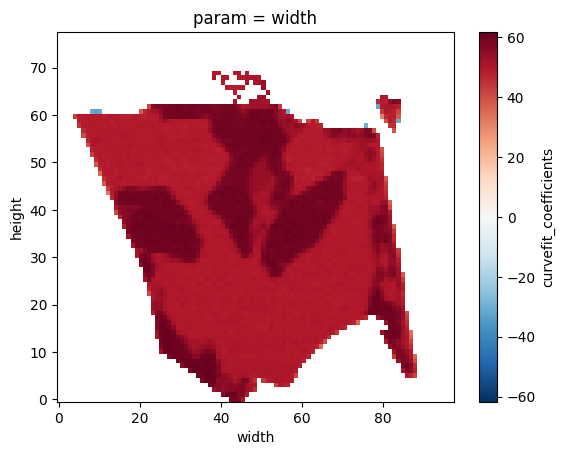

In [196]:
fit['curvefit_coefficients'].sel(param = 'width').plot()

# Testing dask

Let's save a smaller file for testing.

In [ ]:
xrm_small = xrm.sel(width = slice(30, 40), height = slice(30, 40), ramanshift = slice(1300, 1600))

In [ ]:
xrm_small.to_netcdf(data_path + 'xrm_small.nc')

In [ ]:
# Define a function to perform a linear fit and subtract it from the data
def bgsubtract_wrapper(xrobject):
    y_data_nobg, _, _, _, _ = rt.bgsubtract(xrobject['ramanshift'], xrobject.data)
    return y_data_nobg

In [ ]:
# Initialize an empty xarray DataArray to store the result
xrm_subtracted = xr.zeros_like(xrm)

# Iterate over the height and width dimensions
for i in range(len(xrm['height'])):
    for j in range(len(xrm['width'])):
        # Select the data for this pixel
        pixel_data = xrm.isel(height = i, width = j)
        
        # Apply the function to this pixel's data and store the result
        xrm_subtracted.loc[dict(height = xrm['height'][i], width = xrm['width'][j])] = bgsubtract_wrapper(pixel_data)

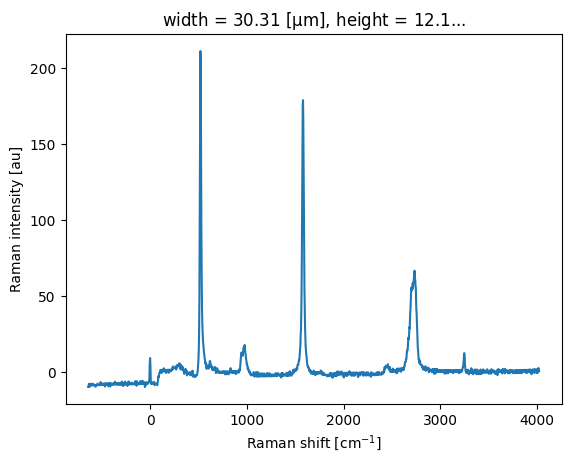

In [ ]:
xrm_subtracted.sel(height = 12, width = 30, method = 'nearest').plot()

# Trying `dask` parallelization

In [ ]:
import dask.array as da

In [ ]:
data = xrm

Reshaping data

In [ ]:
data_flat = xrm.stack(pos = ('height', 'width'))

In [ ]:
data_unstacked = data_flat.unstack('pos')

I'm choosing here a chunk size of 1 in the 'height' and 'width' dimensions.

In [ ]:
# Rechunk the data for parallel computation
data_dask = data.chunk({'height': 1, 'width': 1, 'ramanshift': -1}).data

In [ ]:
# Define a function to apply bgsubtract to a 2D array
# This should take a 1D numpy array and return a 1D numpy array.
def bgsubtract_2d(y_data_2d, x_data):
    # Initialize an array to hold the results
    y_data_nobg_2d = np.empty_like(y_data_2d)

    # Loop over the first dimension
    for i in range(y_data_2d.shape[0]):
        for j in range(y_data_2d.shape[1]):
            # Apply the bgsubtract function
            y_data_nobg, _, _, _, _ = rt.bgsubtract(x_data, y_data_2d[i, j])

            # Store the result
            y_data_nobg_2d[i, j] = y_data_nobg

    return y_data_nobg_2d

In [ ]:
# Apply the function to the data with Dask's map_blocks function
y_data_nobg_dask = da.map_blocks(bgsubtract_2d, data_dask, data['ramanshift'].values, dtype = data_dask.dtype)

In [ ]:
# Convert the result back to xarray DataArray
y_data_nobg = xr.DataArray(
    y_data_nobg_dask,
    dims=["ramanshift", "height", "width"],
    coords={"ramanshift": data.ramanshift, "height": data.height, "width": data.width}
)


Now the chunks are of size 1. So the bgsubtract wrapper doesn't need to loop. Let's see

In [ ]:
data_dask = data_flat.chunk({'pos': 1, 'ramanshift': -1}).data

In [ ]:
data_dask

dask.array<xarray-<this-array>, shape=(1600, 7469), dtype=float64, chunksize=(1600, 1), chunktype=numpy.ndarray>

In [ ]:
def bgsubtract_wrap(y_data):
    y_data_nobg = np.empty_like(y_data)
    rshift = data_flat['ramanshift'].values
    y_data_nobg, _, _, _, _ = rt.bgsubtract(rshift, y_data)
    return y_data_nobg

In [ ]:
y_data_nobg_dask = da.map_blocks(bgsubtract_wrap, data_dask, dtype = data_dask.dtype)

In [ ]:
data_flat_res = y_data_nobg_dask.compute()

ValueError: `x` must be a 1-D array

Simple `dask` example

In [ ]:
# Create a large 3D array with Dask.
x = da.random.random((1000, 100, 100), chunks=(100, 100, 100))

In [ ]:
x

dask.array<random_sample, shape=(1000, 100, 100), dtype=float64, chunksize=(100, 100, 100), chunktype=numpy.ndarray>

In [ ]:
def linear_fit(data):
    """Apply a linear fit to the data along the first axis."""
    # Reshape the data to 2D.
    original_shape = data.shape
    data = data.reshape(original_shape[0], -1)
    x = np.arange(data.shape[0])
    y = data
    coeffs = np.polyfit(x, y, 1)
    # We need to reshape the coefficients back to the original shape before returning them.
    return coeffs.reshape((coeffs.shape[0],) + original_shape[1:])


In [ ]:
result = x.map_blocks(linear_fit, dtype=x.dtype, drop_axis=0, new_axis=[0])

In [ ]:
computed_result = result.compute()

In [ ]:
computed_result.shape

(2, 100, 100)

Using `xarray`

In [ ]:
# Create a DataArray with the same data as before
x = xr.DataArray(da.random.random((1000, 100, 100), chunks=(100, 100, 100)), dims=['x', 'y', 'z'])

In [ ]:
def linear_fit(data):
    """Apply a linear fit to the data along the first axis."""
    # Reshape the data to 2D.
    data_array = data.values
    original_shape = data_array.shape
    data_array = data_array.reshape(original_shape[0], -1)
    x = np.arange(data_array.shape[0])
    y = data_array
    coeffs = np.polyfit(x, y, 1)
    # We need to reshape the coefficients back to 3D before returning them.
    return xr.DataArray(coeffs.reshape((-1,) + original_shape[1:]), dims=['coeff', 'y', 'z'])


In [ ]:
# Create a template with the same chunking as the original array
template = xr.DataArray(da.zeros((2,) + x.shape[1:], chunks=(2,) + x.chunks[1:]), dims=['coeff', 'y', 'z'])


In [ ]:
result = x.map_blocks(linear_fit, template=template)

In [ ]:
computed_result = result.compute()

In [ ]:
computed_result

<xarray.DataArray 'zeros_like-c0374c545df1e190b6c6f6caa4031477' (coeff: 2,
                                                                 y: 100, z: 100)>
array([[[-1.48126079e-03, -1.10084648e-03,  1.81801329e-03, ...,
          3.78356845e-04, -1.37498139e-03,  1.01976240e-03],
        [ 1.52428956e-03, -7.23753209e-04, -7.64097342e-04, ...,
          9.11552458e-04, -7.31586733e-04, -1.38176448e-03],
        [ 9.87746183e-05, -1.19424381e-03,  3.36971224e-04, ...,
         -5.32753919e-04, -9.10767862e-04,  3.05598464e-04],
        ...,
        [-5.88950719e-04, -6.44343798e-04,  1.45432423e-03, ...,
         -1.06168400e-03, -4.13515328e-04,  2.09126227e-04],
        [ 9.14656160e-04, -1.50586129e-03,  1.87964993e-03, ...,
         -1.64225261e-03,  3.85261102e-04, -5.64069251e-04],
        [ 5.29288683e-04,  7.01806816e-04,  3.35740321e-04, ...,
          1.53482120e-04,  1.19332089e-03,  7.35516636e-04]],

       [[ 5.99519658e-01,  5.12086930e-01,  3.88351740e-01, ...,
          4.73463313e-01,  5.84792173e-01,  4.46749488e-01],
        [ 4.70138999e-01,  5.17906604e-01,  5.42134771e-01, ...,
          4.36566184e-01,  5.27894254e-01,  5.57201871e-01],
        [ 5.07668890e-01,  5.42714879e-01,  4.69588256e-01, ...,
          5.26278216e-01,  4.96123108e-01,  4.70833159e-01],
        ...,
        [ 4.88655182e-01,  5.26170321e-01,  4.51185490e-01, ...,
          5.57048264e-01,  4.97828729e-01,  4.49298218e-01],
        [ 4.93387581e-01,  6.12720976e-01,  3.96405773e-01, ...,
          5.63833140e-01,  4.55590812e-01,  5.05034629e-01],
        [ 4.78569921e-01,  5.24803438e-01,  4.92599519e-01, ...,
          4.45191230e-01,  4.68153589e-01,  4.68384579e-01]]])
Dimensions without coordinates: coeff, y, z